# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

In [52]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [54]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

In [55]:
DATASET_NAME = 'off-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [56]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays=workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [57]:
data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01015,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,1637.344974,1805.0000,NaN,NaN,NaN,NaN,705.4995
1,01016,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,293.344724,159.1128,NaN,NaN,NaN,NaN,160.0957
2,01022,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,59.144115,72.4900,NaN,NaN,NaN,NaN,74.4420
3,01026,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,10.669629,23.8392,NaN,NaN,NaN,NaN,8.8567
4,01027,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,NaN,0.935714,NaN,1.014286,NaN,False,NaN,NaN,2.109411,3.9600,NaN,NaN,NaN,NaN,4.9003


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47370 entries, 0 to 47369
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          47370 non-null  object 
 1   ProductGroup      47370 non-null  object 
 2   PrimaryPack       47370 non-null  object 
 3   Country           47370 non-null  object 
 4   Year              47370 non-null  int64  
 5   Week              47370 non-null  int64  
 6   NumberWorkdays    47370 non-null  int64  
 7   AvgTemp           47370 non-null  float64
 8   PrevWeekAvgTemp   47230 non-null  float64
 9   AvgRain           47370 non-null  float64
 10  PrevWeekAvgRain   47230 non-null  float64
 11  AvgSun            47370 non-null  float64
 12  PrevWeekAvgSun    47230 non-null  float64
 13  IsLockdown        47370 non-null  bool   
 14  PdtHl             31583 non-null  float64
 15  PrevWeekPdtHl1    31099 non-null  float64
 16  BgtHl             38250 non-null  float6

In [59]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,PrevWeekAvgTemp,AvgRain,PrevWeekAvgRain,AvgSun,PrevWeekAvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,47370.000000,47370.000000,47370.000000,47370.000000,47230.000000,47370.000000,47230.000000,47370.000000,47230.000000,31583.000000,31099.000000,38250.000000,47370.000000,45693.000000,45201.00000,32889.000000,22975.000000,44399.000000
mean,2018.288790,25.958814,4.786067,10.237012,10.236828,1.667135,1.658566,4.886455,4.884062,596.175524,589.179120,692.342153,632.306577,645.252758,643.35303,702.373177,740.006797,670.498595
std,1.537524,15.120928,0.494518,7.686132,7.687616,1.653714,1.640552,3.003828,3.014412,1523.850336,1507.273611,1465.157105,1545.808939,1562.073184,1563.79518,1632.683176,1682.785434,1566.366967
min,2016.000000,1.000000,2.000000,-8.278571,-8.278571,0.000000,0.000000,0.142857,0.142857,0.052800,0.052800,-28.562282,0.000000,0.000000,0.00000,0.000000,0.000000,0.062100
25%,2017.000000,13.000000,5.000000,3.478571,3.478571,0.464286,0.464286,2.164286,2.164286,26.623818,26.666667,51.803314,24.480000,27.600000,27.96000,41.040000,51.760000,36.432700
50%,2018.000000,25.000000,5.000000,9.835714,9.835714,1.131250,1.131250,4.707143,4.707143,118.377880,118.000000,187.370175,123.000000,128.880000,129.12000,166.200000,185.640000,150.000000
75%,2020.000000,39.000000,5.000000,17.664286,17.664286,2.307143,2.307143,7.135165,7.135165,461.284618,458.173976,666.210000,534.120000,552.120000,549.70000,635.520000,678.740000,600.285850
max,2021.000000,53.000000,5.000000,25.814286,25.814286,7.957143,7.957143,13.864286,13.864286,25903.784615,25903.784615,16006.808529,24281.500000,24281.500000,24281.50000,24281.500000,23150.600000,24865.201400


## Missing Values

In [60]:
data.isna().sum()

SkuShort            0    
ProductGroup        0    
PrimaryPack         0    
Country             0    
Year                0    
Week                0    
NumberWorkdays      0    
AvgTemp             0    
PrevWeekAvgTemp     140  
AvgRain             0    
PrevWeekAvgRain     140  
AvgSun              0    
PrevWeekAvgSun      140  
IsLockdown          0    
PdtHl               15787
PrevWeekPdtHl1      16271
BgtHl               9120 
SalesHl             0    
PrevWeekSalesHl1    1677 
PrevWeekSalesHl2    2169 
PrevYearSalesHl1    14481
PrevYearSalesHl2    24395
OldPredSalesHl      2971 
dtype: int64

## Data Visualizations

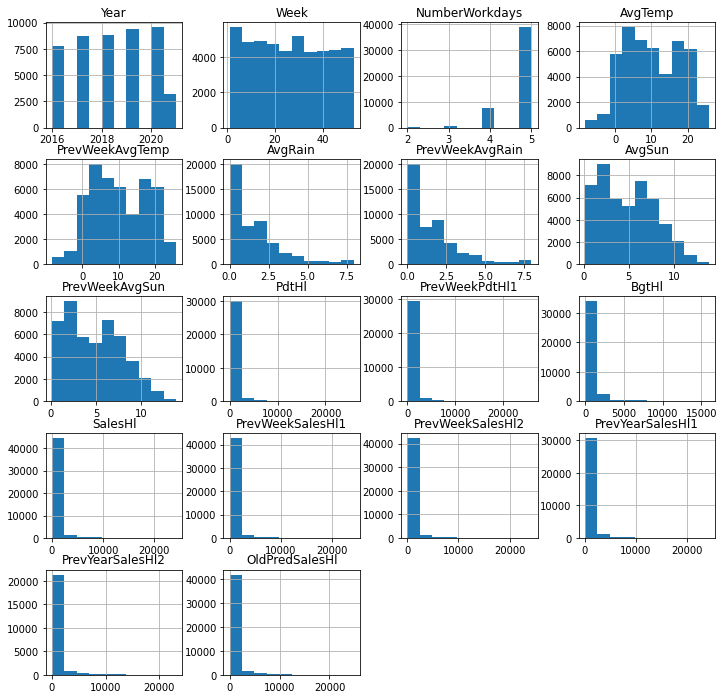

In [61]:
data.hist(figsize=[12,12])
plt.show()

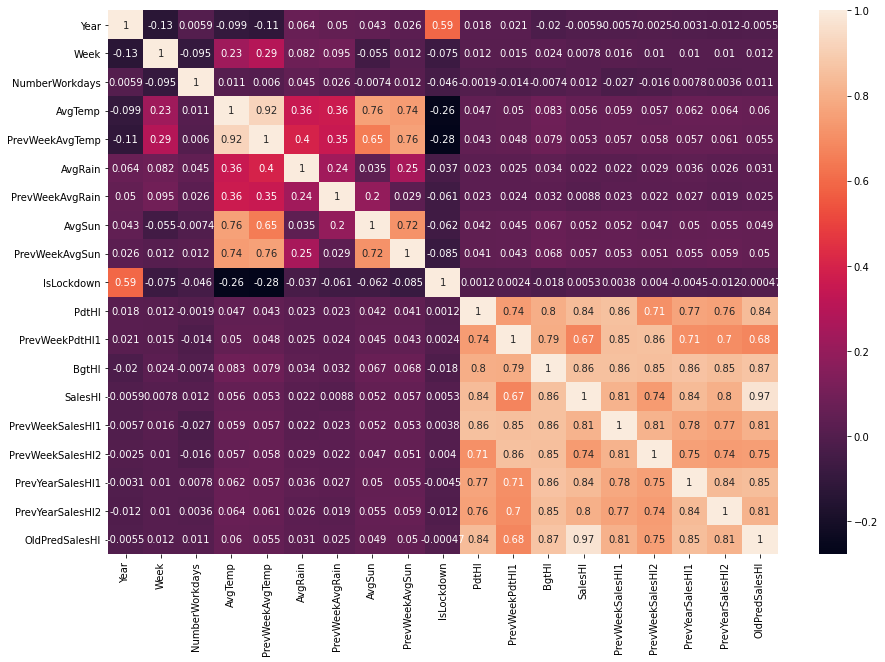

In [62]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

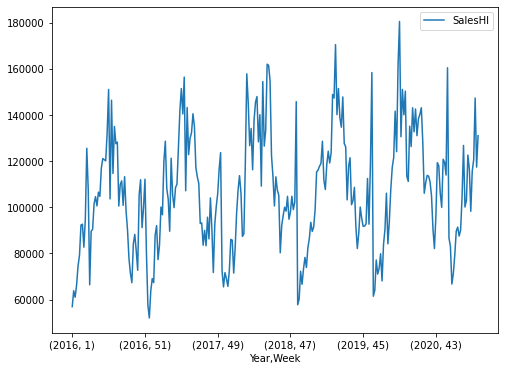

In [63]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

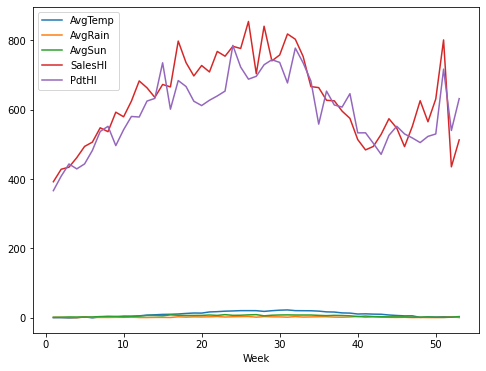

In [64]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

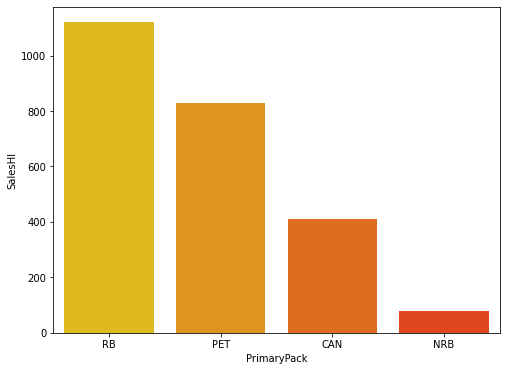

In [65]:
plt.figure(figsize=(8,6))
g_pps = data.groupby('PrimaryPack')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('PrimaryPack')
axis.set_ylabel('SalesHl')

plt.show()

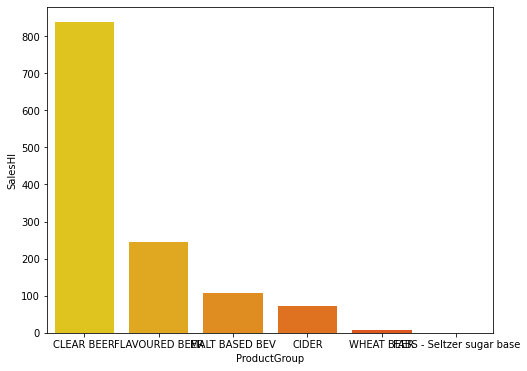

In [66]:
plt.figure(figsize=(8,6))
g_pgs = data.groupby('ProductGroup')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pgs.index, y=g_pgs, palette='autumn_r')
axis.set_xlabel('ProductGroup')
axis.set_ylabel('SalesHl')
plt.show()

In [67]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.971600
BgtHl,0.858548
PdtHl,0.843614
PrevYearSalesHl1,0.839132
PrevWeekSalesHl1,0.811426
PrevYearSalesHl2,0.803883
PrevWeekSalesHl2,0.736750
PrevWeekPdtHl1,0.672481
PrevWeekAvgSun,0.056598


## Skewness and Kurtesis

In [68]:
data.skew()

SkuShort            0.661407
Year                0.012496
Week                0.065851
NumberWorkdays     -2.629699
AvgTemp             0.025509
PrevWeekAvgTemp     0.028975
AvgRain             1.562984
PrevWeekAvgRain     1.580611
AvgSun              0.405940
PrevWeekAvgSun      0.408411
IsLockdown          1.949256
PdtHl               5.791706
PrevWeekPdtHl1      5.788678
BgtHl               4.611346
SalesHl             5.447783
PrevWeekSalesHl1    5.390741
PrevWeekSalesHl2    5.459741
PrevYearSalesHl1    5.240190
PrevYearSalesHl2    5.124643
OldPredSalesHl      5.244231
dtype: float64

In [69]:
data.kurt()

SkuShort           -0.589661 
Year               -1.135166 
Week               -1.216751 
NumberWorkdays      7.991336 
AvgTemp            -1.044248 
PrevWeekAvgTemp    -1.042982 
AvgRain             2.394466 
PrevWeekAvgRain     2.533989 
AvgSun             -0.686573 
PrevWeekAvgSun     -0.699000 
IsLockdown          1.799677 
PdtHl               45.669482
PrevWeekPdtHl1      45.028016
BgtHl               26.463615
SalesHl             39.222667
PrevWeekSalesHl1    38.376193
PrevWeekSalesHl2    39.529414
PrevYearSalesHl1    35.846622
PrevYearSalesHl2    33.831348
OldPredSalesHl      36.068394
dtype: float64

## Create X, y

In [70]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'ProductGroup', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun' 'BgtHl',

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


In [71]:
# X['NextWeek'] = X['Week']+1
# X['PrevWeek'] = X['Week']-1

# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

# X = X.drop(['NextWeek', 'PrevWeek', 'WeekPrev', 'WeekNext'], axis=1)
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
# X

## LabelEncoder

In [72]:
# create Temp
# bins = [-np.inf, -1, 1, 10, 15, 20, np.inf]
# names = ['mraz', 'kolem nuly', 'chladno', 'teplo', 'velmi teplo', 'horko']
# X['Temp'] = pd.cut(X['AvgTemp'], bins=bins, labels=names)
# X['PrevWeekTemp'] = pd.cut(X['PrevWeekAvgTemp'], bins=bins, labels=names)

# #create Rain
# bins = [0, 0.1, 2.5, 8, 40, np.inf]
# names = ['velmi slabá', 'slabá', 'mírná', 'silná', 'velmi silná']
# X['Rain'] = pd.cut(X['AvgRain'], bins=bins, labels=names)
# X['PrevWeekRain'] = pd.cut(X['PrevWeekAvgRain'], bins=bins, labels=names)

# #create Sun
# bins = [0, 2, 5, 8, np.inf]
# names = ['zatazeno', 'oblacno', 'polojasno', 'jasno']
# X['Sun'] = pd.cut(X['AvgSun'], bins=bins, labels=names)
# X['PrevWeekSun'] = pd.cut(X['PrevWeekAvgSun'], bins=bins, labels=names)

# X.Rain = LabelEncoder().fit_transform(X.Rain)
# X.Temp = LabelEncoder().fit_transform(X.Temp)
# X.Sun = LabelEncoder().fit_transform(X.Sun)
# X.PrevWeekTemp = LabelEncoder().fit_transform(X.PrevWeekTemp)
# X.PrevWeekRain = LabelEncoder().fit_transform(X.PrevWeekRain)
# X.PrevWeekSun = LabelEncoder().fit_transform(X.PrevWeekSun)

# X = X.drop(['AvgTemp', 'AvgRain', 'AvgSun', 'PrevWeekAvgTemp', 'PrevWeekAvgRain', 'PrevWeekAvgSun'], axis=1)

#round weather
# X.AvgTemp = X.AvgTemp.round(1)#.astype('int64')
# X.AvgRain = X.AvgRain.round(1)#.astype('int64')
# X.AvgSun = X.AvgSun.round(1)#.astype('int64')

In [73]:
Country_mapping = {"CZ": 1, "SK": 2}
PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

el = LabelEncoder()
X.SkuShort = el.fit_transform(X.SkuShort)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,3,1,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1637.344974,NaN,NaN,NaN,NaN
1,1,3,1,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,293.344724,NaN,NaN,NaN,NaN
2,2,3,1,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,59.144115,NaN,NaN,NaN,NaN
3,4,3,1,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,10.669629,NaN,NaN,NaN,NaN
4,5,3,1,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,2.109411,NaN,NaN,NaN,NaN


## Imputer

In [74]:
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [75]:
si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [76]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)#.astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)#.astype('int64')

# X['SalesPerPdt'] = X['PrevWeekSalesHl1'].divide(X['PrevWeekPdtHl1'], fill_value=0) #dataset['PrevWeekSalesHl1'] / dataset['PrevWeekPdtHl1']
# X['SalesPerPdt'] = X['SalesPerPdt'].replace([np.inf, -np.inf, np.nan], 0)

X.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,3.0,1.0,2016.0,1.0,5.0,-1.164286,0.935714,1.014286,0.0,0.0,0.0,1637.344974,645.252758,643.35303,702.373177,740.006797,644.3,721.2,682.7
1,1.0,3.0,1.0,2016.0,1.0,5.0,-1.164286,0.935714,1.014286,0.0,0.0,0.0,293.344724,645.252758,643.35303,702.373177,740.006797,644.3,721.2,682.7
2,2.0,3.0,1.0,2016.0,1.0,5.0,-1.164286,0.935714,1.014286,0.0,0.0,0.0,59.144115,645.252758,643.35303,702.373177,740.006797,644.3,721.2,682.7
3,4.0,3.0,1.0,2016.0,1.0,5.0,-1.164286,0.935714,1.014286,0.0,0.0,0.0,10.669629,645.252758,643.35303,702.373177,740.006797,644.3,721.2,682.7
4,5.0,3.0,1.0,2016.0,1.0,5.0,-1.164286,0.935714,1.014286,0.0,0.0,0.0,2.109411,645.252758,643.35303,702.373177,740.006797,644.3,721.2,682.7


In [77]:
X.tail()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
47365,254.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,0.000000,0.000000,19.560704,1.4256,7.9200,1.742400,740.006797,4.7,370.9,187.8
47366,272.0,4.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,65.595430,26.024002,692.342153,149.0544,134.1648,702.373177,740.006797,141.6,721.2,431.4
47367,274.0,4.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,59.595430,21.595430,692.342153,114.8400,108.9792,702.373177,740.006797,111.9,721.2,416.5
47368,279.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,77.928504,197.214218,164.929034,126.6000,267.7200,142.560000,71.880000,197.2,107.2,152.2
47369,285.0,1.0,2.0,2021.0,19.0,5.0,14.105495,5.594505,5.882418,1.0,55.279089,138.136232,83.367762,80.5200,197.5200,56.160000,47.880000,139.0,52.0,95.5


## Split train, test

In [78]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)

#X = X.drop(['Year'], axis=1)
# X['Year'] = (X['Year']-1900).astype(int)
 
X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
45646,0.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,7361.289056,5214.431913,6846.230237,8267.8000,4305.70000,9069.800000,7285.300000,6286.8,8177.6,7232.2
45647,1.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,302.937182,331.508610,413.645388,109.9296,230.63040,175.111200,157.132800,170.3,166.1,168.2
45648,5.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,0.000000,0.000000,7.049176,9.8208,10.45440,5.940000,17.424000,10.1,11.7,10.9
45649,7.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,0.000000,14.285714,450.519687,519.0800,364.84000,168.520000,266.840000,442.0,217.7,329.8
45650,8.0,3.0,1.0,2021.0,10.0,5.0,2.33956,0.876923,3.383516,1.0,252.000000,0.000000,692.342153,864.0000,643.35303,702.373177,740.006797,753.7,721.2,737.4


## Scaler

In [79]:
#scaler = MinMaxScaler() #0.8361
#scaler = MaxAbsScaler() #0.8335
scaler = StandardScaler() #0.8381
#scaler = RobustScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# y_train = np.log1p(y_train)
# X_test = np.log1p(X_test)

## Regressor

In [80]:
# # model = ensemble.RandomForestRegressor(random_state=0, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)
# model = neural_network.MLPRegressor(random_state=0, early_stopping=False)

# #mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant',  shuffle=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)

# # param_grid = dict(hidden_layer_sizes=[100], activation=['relu'], solver=['adam'], max_iter=[200], warm_start=[True, False], shuffle=[False])
# param_grid = dict(hidden_layer_sizes=[100, 120], activation=['relu'], solver=['sgd'], max_iter=[200, 250], warm_start=[True, False], shuffle=[True,False])
# clf = GridSearchCV(model, param_grid, n_jobs=6) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)




# 0.439199355969353
# {'activation': 'relu', 'hidden_layer_sizes': 100, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': False, 'solver': 'adam', 'warm_start': True}

In [81]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
# model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
# model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
# model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049




# hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
# mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
#rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=4)


# xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)
# # lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)
# model = LGBMRegressor() #0.8059



#model = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)#0.8467


# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))



#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418

 #0.8929

In [82]:
#asdfasd

### HistGradientBoostingRegressor 

In [83]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

### MLPRegressor

In [84]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [85]:
rfModel = ensemble.RandomForestRegressor(random_state=0, n_estimators=1000, max_depth=None, max_features=None, bootstrap=True, criterion='mse', oob_score=True, n_jobs=2)

### XGBRegressor

In [86]:
xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=4)

### CatBoostRegressor

In [87]:
cbModel = CatBoostRegressor(learning_rate=0.1, eval_metric='RMSE', verbose=0)

In [88]:
lModel = linear_model.Lasso(random_state=0, selection='random')

In [89]:
lgbmModel = LGBMRegressor(n_jobs=3)

In [90]:
ardModel = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False)

In [91]:
brModel = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

In [92]:
gbrModel = ensemble.GradientBoostingRegressor()

In [93]:
knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)

In [94]:
lsvrModel = svm.LinearSVR()

In [95]:
lrModel = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

### Use models

In [96]:
regression_models = [cbModel, xgbModel, hgbModel, rfModel,  mlpModel,  lModel, lgbmModel, ardModel, brModel, gbrModel, knModel, lsvrModel, lrModel] #, lModel, mlpModel
regression_models

 XGBRegressor(base_score=None, booster='dart', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method='approx', validate_parameters=None,
              verbosity=None),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=350, max_leaf_nodes=70, random_state=0),
 RandomForestRegressor(max_features=None, n_estimators=1000, n_jobs=2,
                       oob_score=True, random_state=0),
 MLPRegressor(hidden_layer_sizes=100, max_iter=1000, random_state=0,
              shu

In [97]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', 'MSE', 'RMSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train.values.ravel())
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, mse, rmse, mae]

    estimators.append((model_name, reg_model))

In [98]:
result_models["Weights"] = result_models['Score'].map(lambda x: round(x, 2))
result_models.sort_values(by=['Score'], ascending=False)


#off-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.866791	333804.805779	333804.805779	244.611777	0.87
# 6	LGBMRegressor	0.864042	340693.041703	340693.041703	254.249443	0.86
# 2	HistGradientBoostingRegressor	0.861159	347916.449315	347916.449315	254.998749	0.86
# 0	CatBoostRegressor	0.849278	377688.576685	377688.576685	261.573181	0.85
# 9	GradientBoostingRegressor	0.843769	391493.638902	391493.638902	264.494670	0.84
# 4	MLPRegressor	0.839527	402124.902408	402124.902408	278.039271	0.84
# 12	LinearRegression	0.832977	418538.501574	418538.501574	308.129606	0.83
# 5	Lasso	0.832871	418803.072085	418803.072085	307.357371	0.83
# 7	ARDRegression	0.832818	418936.806781	418936.806781	307.672709	0.83
# 8	BayesianRidge	0.832793	418999.803428	418999.803428	308.173667	0.83
# 11	LinearSVR	0.829922	426193.915922	426193.915922	270.611320	0.83
# 10	KNeighborsRegressor	0.805067	488476.376995	488476.376995	305.001409	0.81
# 1	XGBRegressor	0.772603	569827.345052	569827.345052	297.754979	0.77
#0.8639


# off-trade all 
# Model	Score	MSE	RMSE	MAE	Weights
# 3	RandomForestRegressor	0.863242	342698.124308	342698.124308	253.080070	0.86
# 0	CatBoostRegressor	0.856949	358466.237150	358466.237150	258.825032	0.86
# 6	LGBMRegressor	0.852578	369419.300542	369419.300542	254.215957	0.85
# 9	GradientBoostingRegressor	0.845160	388009.121076	388009.121076	266.951707	0.85
# 2	HistGradientBoostingRegressor	0.840550	399559.836249	399559.836249	263.114173	0.84
# 11	LinearSVR	0.831542	422133.255553	422133.255553	272.425765	0.83
# 4	MLPRegressor	0.831378	422545.200485	422545.200485	280.261420	0.83
# 5	Lasso	0.820057	450913.735936	450913.735936	324.162840	0.82
# 12	LinearRegression	0.819906	451290.911149	451290.911149	325.064277	0.82
# 7	ARDRegression	0.819823	451499.454730	451499.454730	324.979342	0.82
# 8	BayesianRidge	0.819767	451641.430876	451641.430876	325.251593	0.82
# 10	KNeighborsRegressor	0.819618	452014.059650	452014.059650	295.524942	0.82
# 1	XGBRegressor	0.791777	521779.815311	521779.815311	303.154027	0.79
#0.8593


#on-trade
# Model	Score	MSE	RMSE	MAE	Weights
# 6	LGBMRegressor	0.891683	46193.121041	46193.121041	88.423377	0.89
# 1	XGBRegressor	0.890533	46683.289154	46683.289154	97.600362	0.89
# 0	CatBoostRegressor	0.859515	59911.323973	59911.323973	98.200393	0.86
# 2	HistGradientBoostingRegressor	0.859226	60034.513630	60034.513630	91.230857	0.86
# 9	GradientBoostingRegressor	0.842605	67122.924254	67122.924254	106.539311	0.84
# 10	KNeighborsRegressor	0.815448	78704.180046	78704.180046	135.666990	0.82
# 3	RandomForestRegressor	0.813403	79576.440824	79576.440824	94.941833	0.81
# 12	LinearRegression	0.811924	80207.259648	80207.259648	170.711040	0.81
# 5	Lasso	0.810957	80619.289766	80619.289766	169.174454	0.81
# 7	ARDRegression	0.810064	81000.421378	81000.421378	170.797118	0.81
# 8	BayesianRidge	0.808762	81555.376370	81555.376370	171.263265	0.81
# 11	LinearSVR	0.791987	88709.547162	88709.547162	123.906669	0.79
# 4	MLPRegressor	0.599296	170884.695195	170884.695195	177.887054	0.60
#0.8598

,Model,Score,MSE,RMSE,MAE,Weights
3,RandomForestRegressor,0.863242,342698.124308,342698.124308,253.080070,0.86
0,CatBoostRegressor,0.856949,358466.237150,358466.237150,258.825032,0.86
6,LGBMRegressor,0.852578,369419.300542,369419.300542,254.215957,0.85
9,GradientBoostingRegressor,0.845160,388009.121076,388009.121076,266.951707,0.85
2,HistGradientBoostingRegressor,0.840550,399559.836249,399559.836249,263.114173,0.84
11,LinearSVR,0.831542,422133.255553,422133.255553,272.425765,0.83
4,MLPRegressor,0.831378,422545.200485,422545.200485,280.261420,0.83
5,Lasso,0.820057,450913.735936,450913.735936,324.162840,0.82
12,LinearRegression,0.819906,451290.911149,451290.911149,325.064277,0.82
7,ARDRegression,0.819823,451499.454730,451499.454730,324.979342,0.82


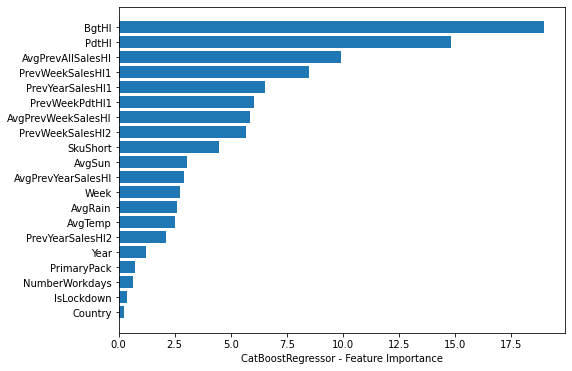

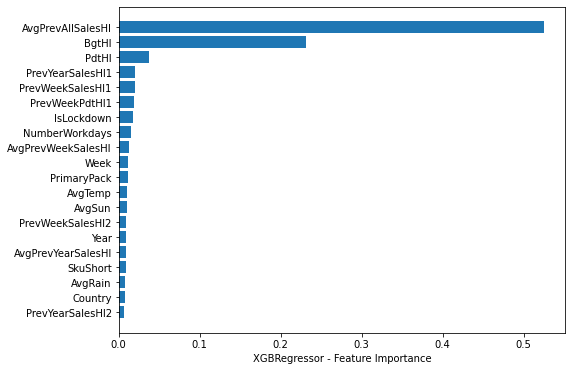

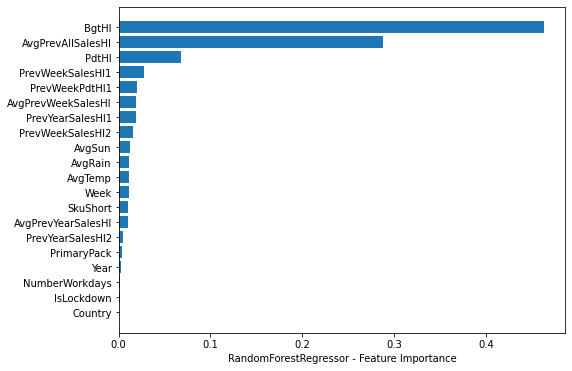

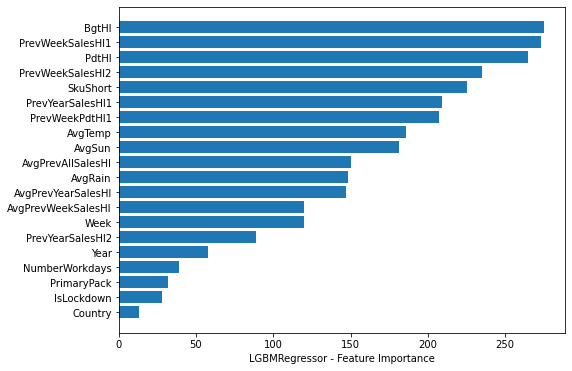

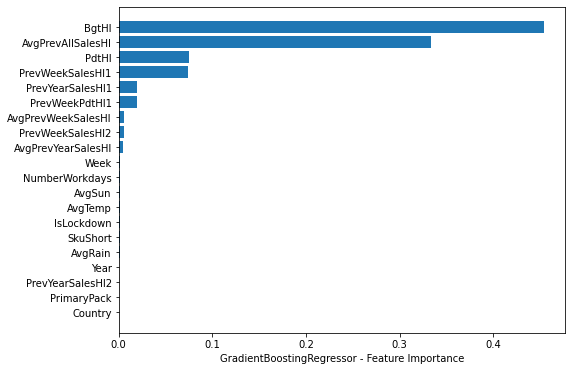

In [99]:
for key, model in estimators:
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8,6))
        sorted_idx = model.feature_importances_.argsort()
        plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
        plt.xlabel(f"{key} - Feature Importance")
        plt.show()

### VotingRegressor

In [100]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))


#off-trade
#0.8613 - [hgbModel, rfModel, xgbModel, cbModel]
#0.8605 - [hgbModel, rfModel, xgbModel, mlpModel, cbModel, lModel]

#on-trade
#0.8075 - [hgbModel, rfModel, xgbModel, mlpModel, cbModel, lModel]
#0.8677

off-trade
Coefficient of determination: 0.8593
Maximum residual error: 5099.0000
Mean absolute percentage error regression loss: 39072122753236952.0000
Old Coefficient of determination: 0.9544
Old Maximum residual error: 4029.0000
Mean absolute percentage error regression loss: 334373986254886.6875


## Model analysis

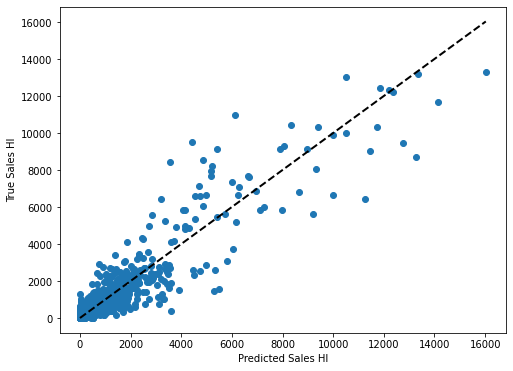

In [101]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel("Predicted Sales Hl")
plt.ylabel("True Sales Hl")

plt.show()

In [102]:
plt.figure(figsize=(8,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

AttributeError: 'VotingRegressor' object has no attribute 'feature_importances_'

In [430]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10    99.2%          76.2%          -23.0%           
     11    92.7%          98.3%          5.7%             
     12    93.5%          96.7%          3.2%             
     13    57.3%          49.3%          -8.0%            
     14    64.8%          93.6%          28.8%            
     15    86.0%          90.3%          4.2%             
     16    99.3%          75.8%          -23.5%           
     17    94.1%          66.3%          -27.8%           
     18    81.8%          87.9%          6.1%             
     19    73.4%          74.1%          0.7%             
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021  82.6%          82.1%          -0.5%            


In [980]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

# X_labels = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_labels)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

exception calling callback for <Future at 0x29f4d15fc10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Program Files\Python39\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "sklearn\tree\_tree.pyx", line 671, in sklearn.tree._tree.Tree.__setstate__
  File "sklearn\tree\_tree.pyx", line 705, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 41, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 1858024 bytes
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\K\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\_b

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [345]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()
X_labels = X.columns.tolist()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=X_labels)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

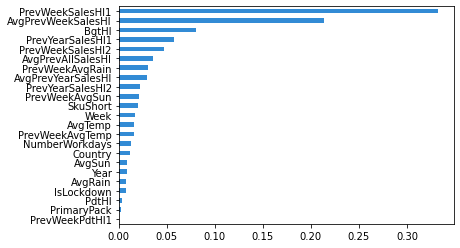

In [346]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [94]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [95]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [96]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [97]:
# shap.plots.force(shap_values[0])

In [98]:
# shap.plots.force(shap_values)

In [99]:
# shap.plots.scatter(shap_values, color=shap_values)

In [100]:
# shap.plots.bar(shap_values)

In [101]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [102]:
result = X_test_raw.copy(deep=True)
result["SalesHl"] = y_test
result["OldPredSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [103]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [104]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363